In [54]:
import pymc as pm

parameter = pm.Exponential('poisson_param', 1)
data_generator = pm.Poisson('data_generator', parameter)
data_plus_one = data_generator + 1

In [55]:
print 'Children of parameter: '
print parameter.children
print '\nParents of data_generator: '
print data_generator.parents
print '\nChildren of data_generator: '
print data_generator.children

Children of parameter: 
set([<pymc.distributions.Poisson 'data_generator' at 0x000000000C783320>])

Parents of data_generator: 
{'mu': <pymc.distributions.Exponential 'poisson_param' at 0x000000000BEE2E10>}

Children of data_generator: 
set([<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x000000000E983518>])


In [56]:
print 'parameter.value = ', parameter.value
print 'data_generator.value =', data_generator.value
print 'data_plus_one.value = ', data_plus_one.value

parameter.value =  0.40627045452
data_generator.value = 0
data_plus_one.value =  1


In [57]:
lambda_1 = pm.Exponential('lambda_1', 1)
lambda_2 = pm.Exponential('lambda_2', 1)
tau = pm.DiscreteUniform('tau', lower=0, upper=10)

print 'lambda_1.value = %.3f' % lambda_1.value
print 'lambda_2.value = %.3f' % lambda_2.value
print 'tau.value = %.3f' % tau.value
print

lambda_1.random(), lambda_2.random(), tau.random()

print 'After calling random() on the variables...'
print 'lambda_1.value = %.3f' % lambda_1.value
print 'lambda_2.value = %.3f' % lambda_2.value
print 'tau.value = %.3f' % tau.value

lambda_1.value = 1.267
lambda_2.value = 1.663
tau.value = 4.000

After calling random() on the variables...
lambda_1.value = 0.003
lambda_2.value = 0.496
tau.value = 5.000


In [58]:
import numpy as np
n_data_points= 5

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

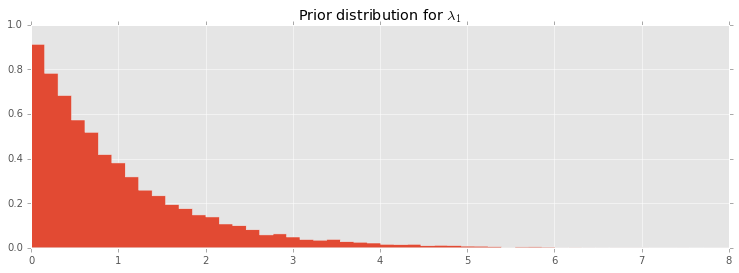

In [59]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(12.5, 4)

plt.style.use('ggplot')

samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype='stepfilled')
plt.title('Prior distribution for $\lambda_1$')
plt.xlim(0, 8);

In [60]:
data = np.array([10, 5])
fixed_variable = pm.Poisson('fxd', 1, value=data, observed=True)
print 'value: ', fixed_variable.value
print 'calling .random()'
fixed_variable.random()
print 'value: ', fixed_variable.value

value:  [10  5]
calling .random()
value:  [10  5]


In [61]:
data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson('obs', lambda_, value=data, observed=True)
print obs.value

[10 25 15 20 35]


In [62]:
model = pm.Model([obs, lambda_, lambda_1, lambda_2, tau])

### Same story; different ending.

In [63]:
tau = pm.rdiscrete_uniform(0, 80)
print tau

26


In [64]:
alpha = 1. / 20.
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print lambda_1, lambda_2

24.0599021131 8.01663612512


In [65]:
data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]

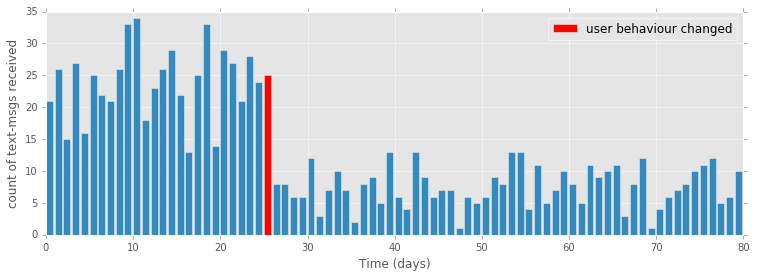

In [66]:
plt.bar(np.arange(80), data, color='#348ABD')
plt.bar(tau - 1, data[tau-1], color='r', label='user behaviour changed')
plt.xlabel('Time (days)')
plt.ylabel('count of text-msgs received')
plt.xlim(0, 80)
plt.legend()

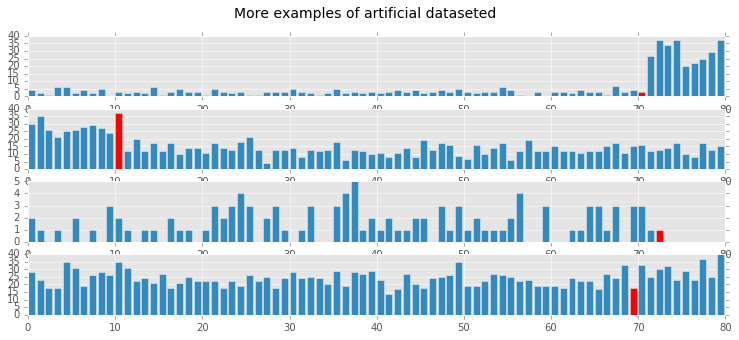

In [68]:
def plot_artificial_sms_dataset():
    tau = pm.rdiscrete_uniform(0, 80)
    alpha = 1. / 20.
    lambda_1, lambda_2 = pm.rexponential(alpha, 2)
    data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]
    plt.bar(np.arange(80), data, color='#348ABD')
    plt.bar(tau - 1, data[tau - 1], color = 'r', label='user behaviour changed')
    plt.xlim(0, 80)
    
figsize(12.5, 5)
plt.suptitle('More examples of artificial dataseted', fontsize=14)
for i in range(1, 5):
    plt.subplot(4, 1, i)
    plot_artificial_sms_dataset()

### Example: Bayesian *A/B* testing

In [99]:
import pymc as pm

p = pm.Uniform('p', lower=0, upper=1)

In [100]:
p_true = 0.05
N = 1500

occurrences = pm.rbernoulli(p_true, N)

print occurrences
print occurrences.sum()

[False False False ..., False False False]
88


In [101]:
print 'What is the observed frequency in the Group A? %.4f' % occurrences.mean()
print 'Does this equal the true frequency? %s' % (occurrences.mean() == p_true)

What is the observed frequency in the Group A? 0.0587
Does this equal the true frequency? False


In [102]:
obs = pm.Bernoulli('obs', p, value=occurrences, observed=True)

mcmc = pm.MCMC([p, obs])
mcmc.sample(18000, 1000)

 [-----------------100%-----------------] 18000 of 18000 complete in 0.8 sec

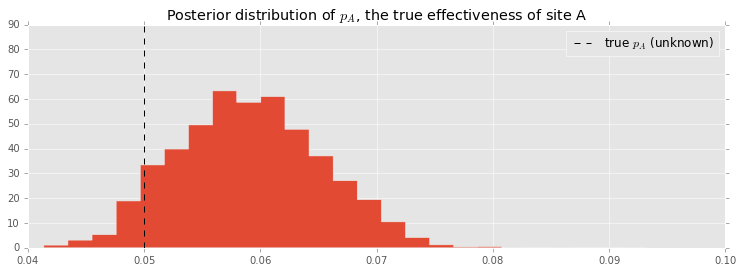

In [103]:
figsize(12.5, 4)
plt.title('Posterior distribution of $p_A$, the true effectiveness of site A')
plt.vlines(p_true, 0, 90, linestyle='--', label='true $p_A$ (unknown)')
plt.hist(mcmc.trace('p')[:], bins=25, histtype='stepfilled', normed=True)
plt.legend();

#### *A* and *B* together 

In [104]:
import pymc as pm
figsize(12, 4)

true_p_A = 0.05
true_p_B = 0.04

N_A = 1500
N_B = 750

observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)
print 'Obs from Site A: ', observations_A[:30].astype(int), '...'
print 'Obs from Site B: ', observations_B[:30].astype(int), '...'

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] ...


In [105]:
print observations_A.mean()
print observations_B.mean()

0.0573333333333
0.0413333333333


In [106]:
p_A = pm.Uniform('p_A', 0, 1)
p_B = pm.Uniform('p_B', 0, 1)

@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

obs_A = pm.Bernoulli('obs_A', p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli('obs_B', p_B, value=observations_B, observed=True)

mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 1.5 sec

In [107]:
p_A_samples = mcmc.trace('p_A')[:]
p_B_samples = mcmc.trace('p_B')[:]
delta_samples = mcmc.trace('delta')[:]

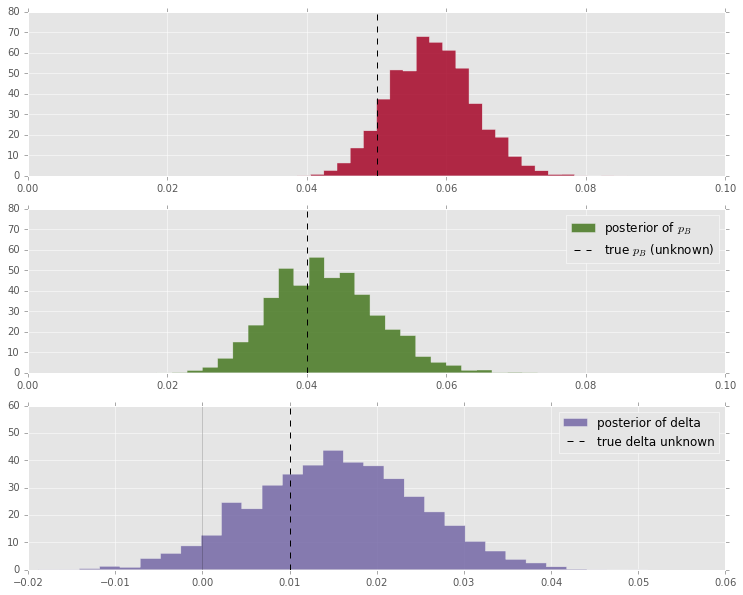

In [108]:
figsize(12.5, 10)

ax = plt.subplot(311)
plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
        label='posterior of $p_A$', color='#A60628', normed=True)
plt.vlines(true_p_A, 0, 80, linestyle='--', label='true $p_A$ (unknown)')

ax = plt.subplot(312)
plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
        label='posterior of $p_B$', color='#467821', normed=True)
plt.vlines(true_p_B, 0, 80, linestyle='--', label='true $p_B$ (unknown)')
plt.legend(loc='upper right')

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
        label='posterior of delta', color='#7468A6', normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle='--',
          label='true delta unknown')
plt.vlines(0, 0, 60, color='black', alpha=0.2)
plt.legend(loc='upper right');

In [109]:
print 'Probability site A is WORSE than site B: %.3f' % \
    (delta_samples < 0).mean()
print 'Probability site A is BETTER than site B %.3f' % \
    (delta_samples > 0).mean()

Probability site A is WORSE than site B: 0.053
Probability site A is BETTER than site B 0.947
